In [1]:
import numpy as np
from formatData import loadData
from qml.kernels import gaussian_kernel
from qml.math import cho_solve
from utils import unison_shuffle
from sklearn.model_selection import train_test_split

In [2]:
"""
Loading data
Note than we can only specify absolute location of the raw data
"""
molRep2D, energies = loadData(12, "/home/panthibivek/thesis/GAN_pkg/data/traj.xyz")
#randomize the data and split it into training and test set
# unison_shuffle(molRep2D, energies)
X_train, X_test, y_train, y_test = train_test_split(molRep2D,energies,
                                   random_state=104, 
                                   test_size=0.3, 
                                   shuffle=True)

print("Training data size:", X_train.shape)
print("Test data size:", X_test.shape)

input data size: (10000, 78)
output data size: (10000,)
Training data size: (7000, 78)
Test data size: (3000, 78)


In [3]:
"""
Regression
"""
def regression(sigma : float, lambda_ : float):
    K = gaussian_kernel(X_train, X_train, sigma)
    K[np.diag_indices_from(K)] += lambda_
    alpha = cho_solve(K, y_train)
    return alpha

"""
Prediction
"""
def prediction(sigma : float, alpha_ : np.array):
    Ks = gaussian_kernel(X_test, X_train, sigma)
    Y_predicted = np.dot(Ks, alpha_)
    return np.mean(np.abs(Y_predicted - y_test))
    

sigmaArr = [float(i) for i in range(50, 250, 50)] + [
    float(i) for i in range(250, 1000, 250)] + [
    float(i) for i in range(1000, 5000, 1000)]
lambda_ = 1e-8
mean_abs_errors = []
for sigma_ in sigmaArr:
    temp_alpha = regression(sigma_, lambda_)
    mean_abs_e = prediction(sigma_, temp_alpha)
    if sigma_ == sigmaArr[0] or mean_abs_e < best_mae:
        argmax_sigma = sigma_
        best_alpha = temp_alpha
        best_mae = mean_abs_e
    mean_abs_errors.append(mean_abs_e)
mae_arr = np.array(mean_abs_errors)

In [4]:
print("Lowest Mean Absolute Error is",mean_abs_e, "when sigma is",argmax_sigma)

Lowest Mean Absolute Error is 0.08159071009916889 when sigma is 150.0


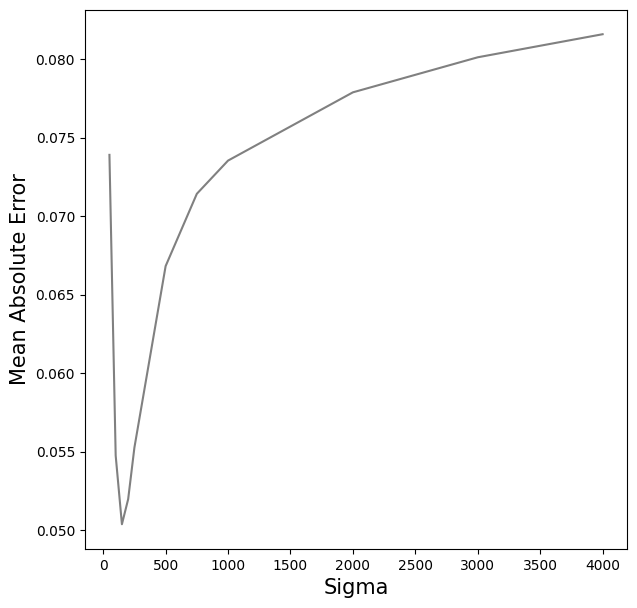

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))
plt.plot(sigmaArr, mae_arr, c="gray")
plt.xlabel('Sigma', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
fig1 = plt.gcf()
plt.show()
fig1.savefig('sigma_vs_MAE.png', dpi = 300)

In [6]:
"""
Best Prediction
"""
Ks = gaussian_kernel(X_test, X_train, argmax_sigma)
Y_predicted = np.dot(Ks, best_alpha)

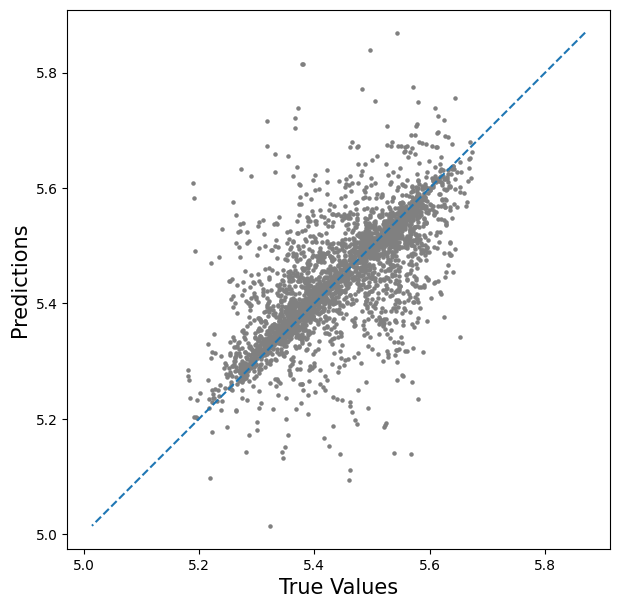

In [7]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(y_test, Y_predicted, c="gray", s=5)

p1 = max(max(Y_predicted), max(y_test))
p2 = min(min(Y_predicted), min(y_test))
plt.plot([p1, p2], [p1, p2], '--')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
fig2 = plt.gcf()
plt.show()
fig2.savefig('actual_vs_prediction.png', dpi = 300)